# Learning Building Thermal Dynamics using Neural ODEs in NeuroMANCER  


This tutorial demonstrates the use of [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366) (NODE) for system identificaiton of building thermal dynamics. 


## Building Thermal Dynamics

Energy-efficient buildings are one of the top priorities to sustainably address the global energy demands and reduction of the CO2 emissions [6]. It has been demonstrated that advanced building control, like [model predictive control (MPC)](https://en.wikipedia.org/wiki/Model_predictive_control)
or [deep reinforcement learning (DRL)](https://en.wikipedia.org/wiki/Deep_reinforcement_learning), can notably reduce the energy use and mitigate greenhouse gas emissions. However, in order for these advanced control methods to work in practice, they heavily rely on accurate prediction models of building thermal dynamics.  

**Schematics of Building Systems**:  
A schematics of different components of a modern building is given as follows:
<img src="./figs/building_model.jpg" width="500">  

Today's buildings are composed of components are the [building envelope](https://en.wikipedia.org/wiki/Building_envelope), [HVAC system](https://en.wikipedia.org/wiki/Heating,_ventilation,_and_air_conditioning), sources of disturbances such as [weather](https://en.wikipedia.org/wiki/Weather_forecasting) and [occupancy](https://en.wikipedia.org/wiki/Occupancy), and the peripherals represented by sensors and actuators.

**Modeling paradigms**:  
For modern advanced control methods, it is of paramout importance to have scalable and easy to use methodologies for constructing prediction models of building thermal dynamics. This can be in general obtained in three conceptual methodologies labeled as [white-box](https://en.wikipedia.org/wiki/White_box_(software_engineering)), [gray-box](https://en.wikipedia.org/wiki/Grey_box_model), or [black-box](https://en.wikipedia.org/wiki/Black_box) models.

<img src="./figs/System_identification_methods.png" width="400">  

The white-box models are constructed competely based on known physical laws, while black-box models are obtained purely using function approximators in a data-driven way, while gray-box models are combination of the two.
For more information about the building modeling methods and tools, we refer the reader to the references below. For a broader overiview of the topic of advanced building control we refer to [9].



## System Identification Problem Setup

The objective of [system identification](https://en.wikipedia.org/wiki/System_identification) is to learn or 'identify' a model of a dynamical system from measured time-series data.
In NODE, this model is parametrized by neural network defining a continuous-time system $\dot{x} = N_{\theta}(x, u)$ to be solver using an ODE integration scheme $\int$. In system identification, the loss $\mathcal{L}$ is evaluated by comparing the  trajectory generated by the model with the training trajectory. The process can be repeated for multiple trajectories to improve the generalization of the model.

<img src="../figs/NODE.PNG" width="600">  


A special case of NODE models  are [Neural Controlled Differential Equations](https://arxiv.org/abs/2005.08926), that allow us to model system that include exogenous.
Then starting from a given initial condition  $x_{0}$, the next state of the system  $x_{k+1}$
is obtained by feeding the current state $x_{k}$ and current input $u_{k}$  into the model $S$. 

<img src="../figs/nonauto_ODE.PNG" width="500">  


### NODE References

[1] [Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, David Duvenaud, Neural Ordinary Differential Equations, NeurIPS 2018](https://arxiv.org/abs/1806.07366)  
[2] [Patrick Kidger, James Morrill, James Foster, Terry Lyons, Neural Controlled Differential Equations for Irregular Time Series, NeurIPS 2020](https://arxiv.org/abs/2005.08926)  
[3] http://implicit-layers-tutorial.org/neural_odes/  
[4] https://github.com/Zymrael/awesome-neural-ode  
[5] [Christian Legaard, Thomas Schranz, Gerald Schweiger, Ján Drgoňa, Basak Falay, Cláudio Gomes, Alexandros Iosifidis, Mahdi Abkar, and Peter Larsen. 2023. Constructing Neural Network Based Models for Simulating Dynamical Systems. ACM Comput. Surv. 55, 11, Article 236 (November 2023), 34 pages.](https://dl.acm.org/doi/10.1145/3567591)

### Building Thermal Dynamics Models References
[6] [Ján Drgoňa, Aaron R. Tuor, Vikas Chandan, Draguna L. Vrabie,
Physics-constrained deep learning of multi-zone building thermal dynamics,
Energy and Buildings, Volume 243,2021](https://www.sciencedirect.com/science/article/pii/S0378778821002760)  
[7] [Zequn Wang, Yuxiang Chen,
Data-driven modeling of building thermal dynamics: Methodology and state of the art,
Energy and Buildings,
Volume 203,
2019](https://www.sciencedirect.com/science/article/abs/pii/S0378778819303913)  
[8] [Samuel Prívara, Jiří Cigler, Zdeněk Váňa, Frauke Oldewurtel, Carina Sagerschnig, Eva Žáčeková,
Building modeling as a crucial part for building predictive control,
Energy and Buildings,
Volume 56,
2013](https://www.sciencedirect.com/science/article/pii/S0378778812005336)  
[9] [Ján Drgoňa, Javier Arroyo, Iago Cupeiro Figueroa, David Blum, Krzysztof Arendt, Donghun Kim, Enric Perarnau Ollé, Juraj Oravec, Michael Wetter, Draguna L. Vrabie, Lieve Helsen,
All you need to know about model predictive control for buildings,
Annual Reviews in Control,
Volume 50,
2020](https://www.sciencedirect.com/science/article/pii/S1367578820300584)  




## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install neuromancer

*Note: When running on Colab, one might encounter a pip dependency error with Lida 0.0.10. This can be ignored*

In [10]:
import torch
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from matplotlib.lines import Line2D

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.plot import pltOL

torch.manual_seed(0);

## Generate trajectories

In this example we don't assume any prior knowledge on the system dynamics of the swing equation. We will only have access to limited measurements of the system states $x$ of an unknown [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation) (ODE).

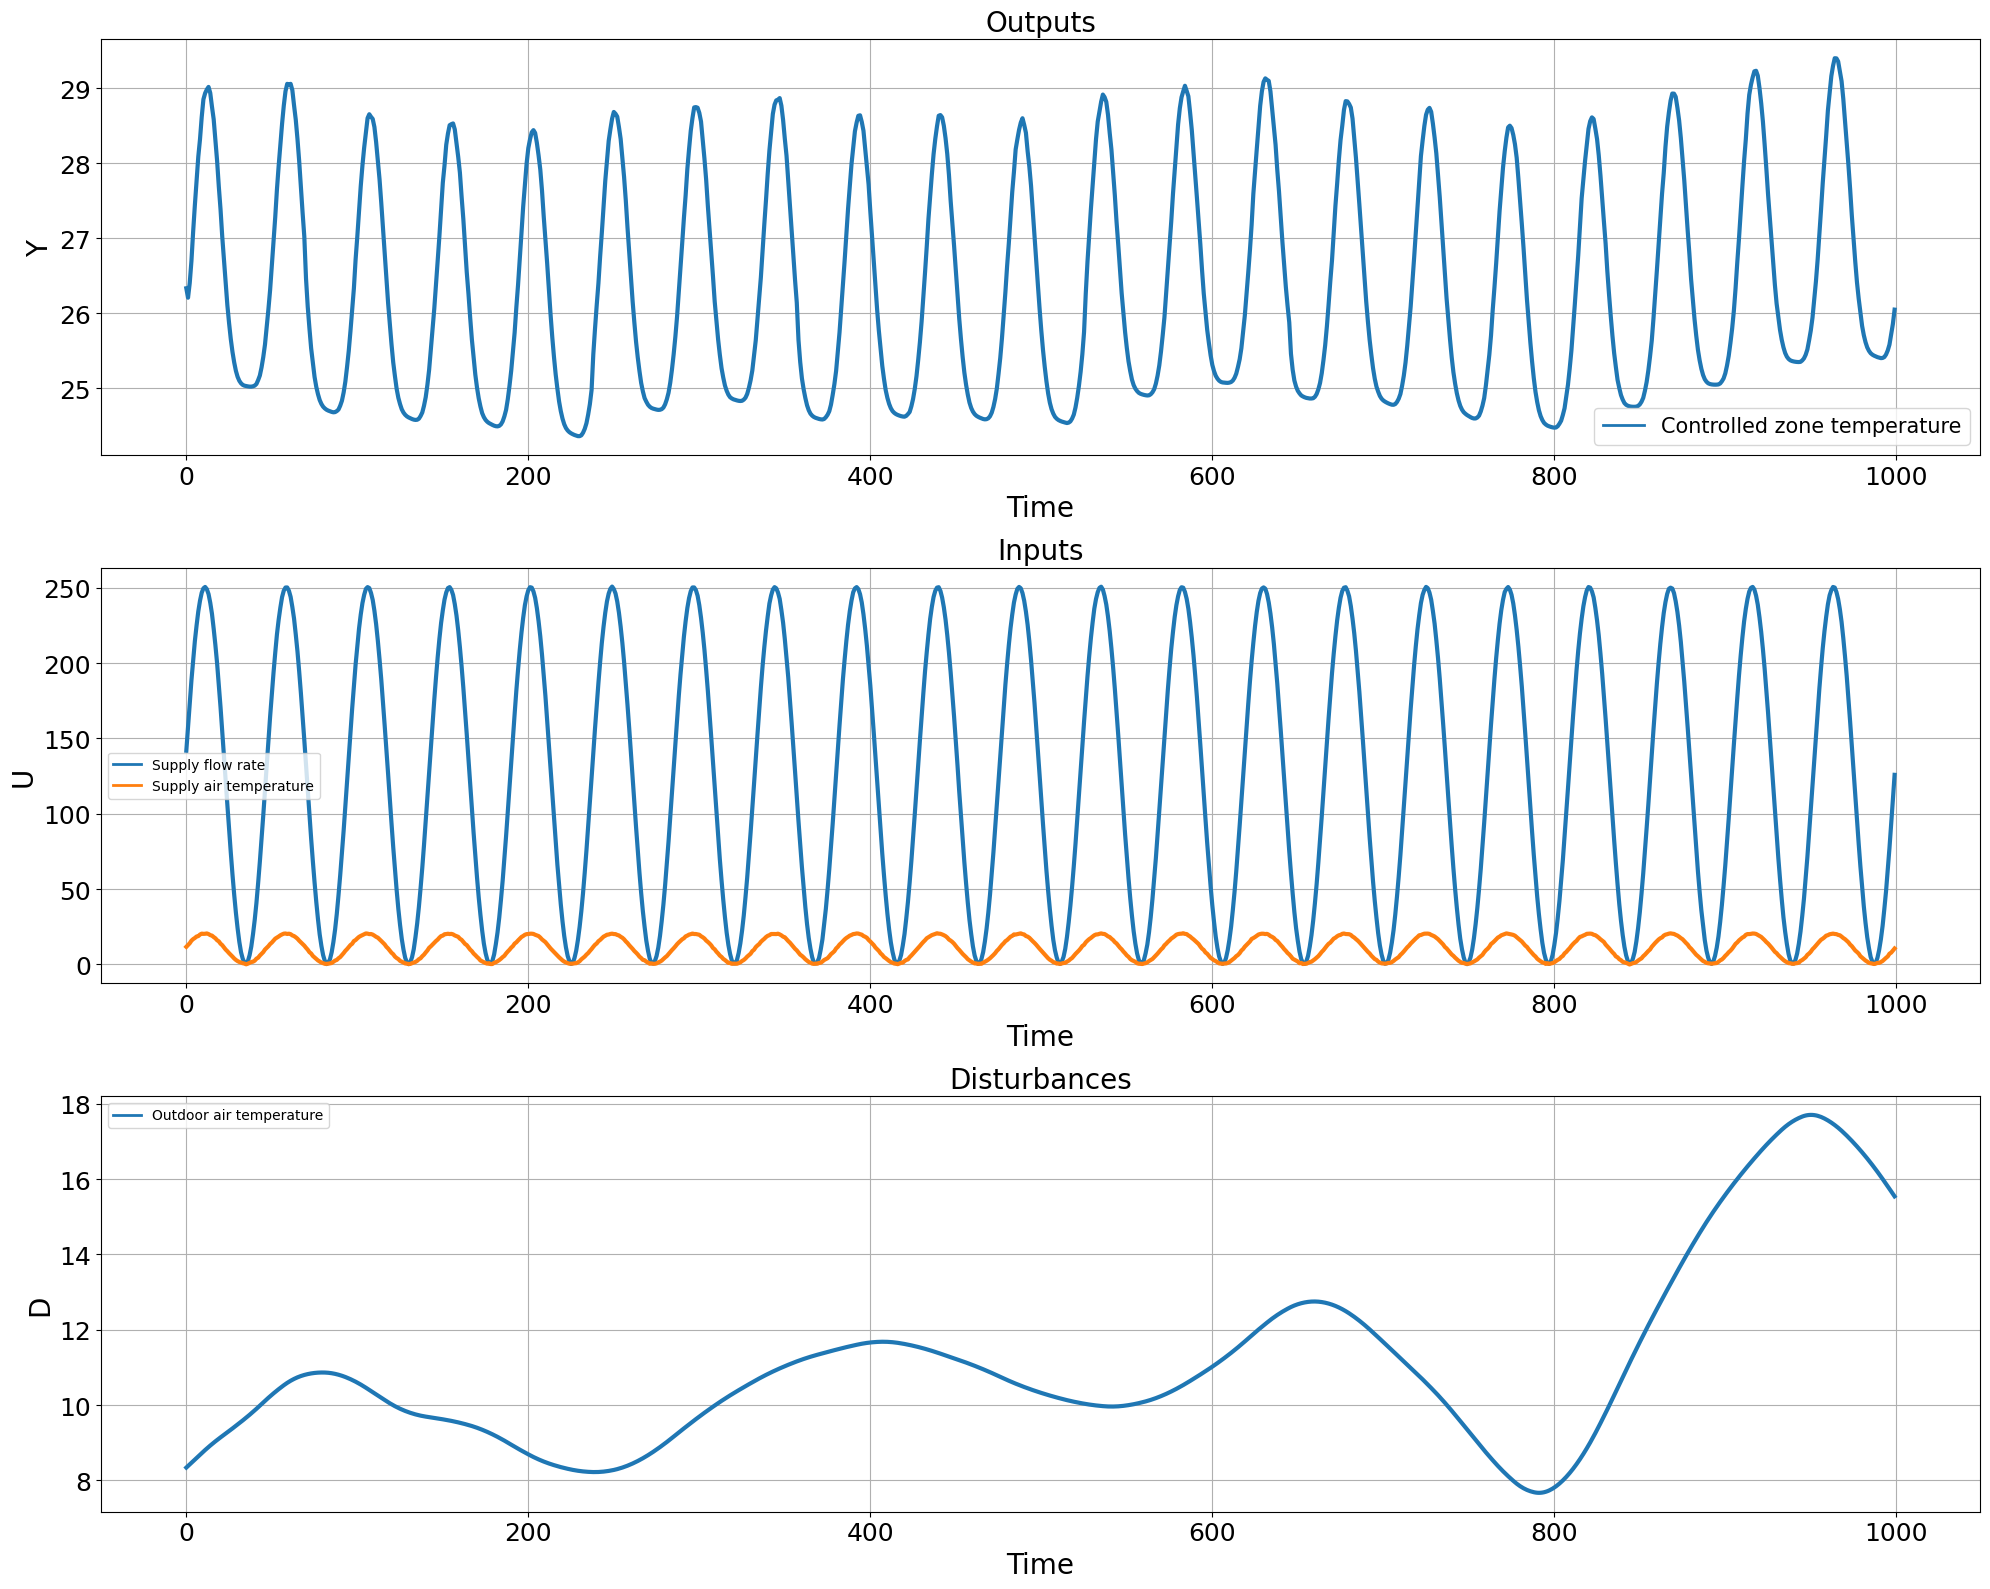

In [35]:
# ground truth system
system_name = "SimpleSingleZone"
system = psl.systems[system_name]
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
ny = modelSystem.ny
nu = modelSystem.nu
nd = modelSystem.nd
raw = modelSystem.simulate(nsim=1000)
fig, ax = pltOL(Y=raw['Y'], U=raw['U'], D=raw['D'])
# add custom legends to plots
custom_lines_1 = [Line2D([0], [0], color='tab:blue', lw=2, linestyle='-')]
custom_lines_2 = [Line2D([0], [0], color='tab:blue', lw=2, linestyle='-'),
                    Line2D([0], [0], color='tab:orange', lw=2, linestyle='-')]
ax[0, 0].legend(custom_lines_1, ['Controlled zone temperature'], fontsize=15, loc="best")
ax[1, 0].legend(custom_lines_2, ['Supply flow rate', 'Supply air temperature'], fontsize=15, loc="best")
ax[2, 0].legend(custom_lines_1, ['Outdoor air temperature'], fontsize=15, loc="best")

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics in the form of input-output-disturbance tuples: 
$$D = \big[(u^i_0, d^i_0, {y}^i_0), ..., (u^i_N,  d^i_N, {y}^i_{N}) \big], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.
Variables $y_k$ represent system states, $d_k$ are system disturbances, and $u_k$ are exogenous inputs at time $k$.


In [14]:
def get_data(sys, nsim, nsteps, ts):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size

    """
    sim = sys.simulate(nsim=nsim, ts=ts)
    nx = sys.nx
    nu = sys.nu
    nd = sys.nd
    ny = sys.ny
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    def normalize(x, mean, std):
        return (x - mean) / std

    X = normalize(sim['X'][:length], modelSystem.stats['X']['mean'], modelSystem.stats['X']['std'])
    X = torch.Tensor(X).reshape(nbatch, nsteps, nx)
    Y = normalize(sim['Y'][:length], modelSystem.stats['Y']['mean'], modelSystem.stats['Y']['std'])
    Y = torch.Tensor(Y).reshape(nbatch, nsteps, ny)
    U = normalize(sim['U'][:length], modelSystem.stats['U']['mean'], modelSystem.stats['U']['std'])
    U = torch.Tensor(U).reshape(nbatch, nsteps, nu)
    D = normalize(sim['D'][:length], modelSystem.stats['D']['mean'], modelSystem.stats['D']['std'])
    D = torch.Tensor(D).reshape(nbatch, nsteps, nd)

    return {"X": X, "yn": Y[:,:1], "Y": Y, "U": U, "D": D}

def get_splits(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size
    """
    train_data, dev_data = [get_data(sys, nsim, nsteps, ts) for _ in range(2)]

    train_data = DictDataset(train_data, name="train")
    train_loader = DataLoader(train_data, batch_size=bs, collate_fn=train_data.collate_fn, shuffle=True)

    dev_data = DictDataset(dev_data, name="dev")
    dev_loader = DataLoader(dev_data, batch_size=bs, collate_fn=dev_data.collate_fn, shuffle=True)

    test_data = get_data(sys, nsim, nsim, ts)
    test_data["name"] = "test"

    return train_loader, dev_loader, test_data

In [15]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 50   # number of prediction horizon steps in the loss function
bs = 10       # minibatching batch size
train_loader, dev_loader, test_data = get_splits(modelSystem, nsim, nsteps, ts, bs)

## Latent space estimator

Because we are dealing with partially observable system dynamics, we need to construct a state estimator to infer the latent states $x_k$ from the observables $y_k$. In this case we construct a black-box encoder model:  
$$x_k = \text{encoder}_{\theta}(y_k)$$

In [16]:
n_latent = 4  # latent state space dimension

# latent state estimator
encoder = blocks.MLP(ny, n_latent, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ReLU,
                hsizes=[40])
encode_sym = Node(encoder, ['yn'], ['xn'], name='encoder')

## NODE system model

Here we construct a non-autonomous latent NODE model  $\dot{x} = f_{\theta}(x, u, d)$ with trainable parameters $\theta$.

In [17]:
# construct latent NODE model in Neuromancer
fx = blocks.MLP(n_latent+nu+nd, n_latent, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.Tanh,
                    hsizes=[40, 40])

Next we need to solve the continuous-time NODE model with suitable ODE solver, e.g., [Runge–Kutta integrator](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods).  
$x_{k+1} = \text{ODESolve}(f_{\theta}(x_k, u_k, d_k))$ 

In [18]:
# integrate NODE with adjoint-based solver
fxRK4 = integrators.RK4(fx, h=ts)
model = Node(fxRK4, ['xn', 'U', 'D'], ['xn'], name='NODE')

Since we are dealing with partially observable system, we need to construct a decoder model to map the latent states onto the system predictions $\hat{y}_k$:  
$$\hat{y}_k = \text{decoder}_{\theta}(x_k)$$

In [19]:
# latent output model
decoder = blocks.MLP(n_latent, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ReLU,
                hsizes=[40])
decode_sym = Node(decoder, ['xn'], ['y'], name='decoder')

Next we construct an open-loop system composed of a symbolic latent NODE model with nstep-ahead rollout.

In [20]:
# latent NODE rollout
dynamics_model = System([model, decode_sym], name='system', nsteps=nsteps)

## Define system identification loss function terms

Here we define loss function terms to fit the ODE parameters from given time-series data.

**Tracking loss:**  
$$\ell_x = Q_N||y^i_k - \hat{y}^i_k||_2^2$$ 
**One-step loss:**  
$$\ell_x = Q_1||y^i_1 - \hat{y}^i_1||_2^2$$ 

In [21]:
# %% Constraints + losses:
y = variable("Y")                      # observed
yhat = variable('y')                   # predicted output

# trajectory tracking loss
reference_loss = 5.*(yhat == y)^2
reference_loss.name = "ref_loss"

# one step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

## Construct System ID learning problem

Given the training dataset $D$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big(Q_1||y^i_1 - \hat{y}^i_1||_2^2 + \sum_{k=1}^{N}  Q_N||y^i_k - \hat{y}^i_k||_2^2   \Big) \\
&\text{subject to}    && \hat{y}^i_{k+1} =  \text{ODESolve}(f_{\theta}(y^i_k, u^i_k, d^i_k)) \\
&   &&  x^i_0 = \text{encoder}_{\theta}(y^i_k) \\
&   && \hat{y}_k = \text{decoder}_{\theta}(x_k)
\end{align}
$$  

In [22]:
# putting things together
nodes = [encode_sym, dynamics_model]
objectives = [reference_loss, onestep_loss]
constraints = []

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)

# construct constrained optimization problem
problem = Problem(nodes, loss)
# plot computational graph
problem.show()

FileNotFoundError: [WinError 2] "dot" not found in path.

## Solve the problem

We fit the unknown model parameters $\theta$ using stochastic gradient descent.

In [23]:
optimizer = torch.optim.Adam(problem.parameters(),
                                lr=0.003)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=100,
    warmup=500,
    epochs=1000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)

None
Number of parameters: 2609


In [24]:
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0	train_loss: 1.73906	dev_loss: 1.84694	eltime:  3.12481
epoch: 1	train_loss: 1.76468	dev_loss: 1.73969	eltime:  3.63315
epoch: 2	train_loss: 1.82931	dev_loss: 1.43465	eltime:  3.97216
epoch: 3	train_loss: 1.58113	dev_loss: 1.57672	eltime:  4.30403
epoch: 4	train_loss: 1.52218	dev_loss: 1.50830	eltime:  4.71714
epoch: 5	train_loss: 1.61470	dev_loss: 1.48222	eltime:  5.13723
epoch: 6	train_loss: 1.57037	dev_loss: 1.47087	eltime:  5.52029
epoch: 7	train_loss: 1.56666	dev_loss: 1.52764	eltime:  5.92902
epoch: 8	train_loss: 1.36869	dev_loss: 1.46767	eltime:  6.32466
epoch: 9	train_loss: 1.33127	dev_loss: 1.48139	eltime:  6.68533
epoch: 10	train_loss: 1.39457	dev_loss: 1.29303	eltime:  7.08676
epoch: 11	train_loss: 1.24086	dev_loss: 1.19207	eltime:  7.47349
epoch: 12	train_loss: 1.01117	dev_loss: 1.08909	eltime:  7.83780
epoch: 13	train_loss: 0.82551	dev_loss: 0.79084	eltime:  8.24583
epoch: 14	train_loss: 0.57254	dev_loss: 0.50044	eltime:  8.66185
epoch: 15	train_loss: 0.36502	dev_l

<All keys matched successfully>

## Parameter estimation results

In [25]:
# update the rollout length based on the test data
problem.nodes[1].nsteps = test_data['Y'].shape[1]

with torch.no_grad():
    test_outputs = problem(test_data)

In [26]:
def denormalize(x, mean, std):
    return (x * std) + mean

pred_traj = denormalize(test_outputs['test_y'], modelSystem.stats["Y"]["mean"], modelSystem.stats["Y"]["std"]).reshape(-1, ny).T
true_traj = denormalize(test_data['Y'], modelSystem.stats["Y"]["mean"], modelSystem.stats["Y"]["std"]).reshape(-1, ny).T
input_traj = denormalize(test_data['U'], modelSystem.stats["U"]["mean"], modelSystem.stats["U"]["std"]).reshape(-1, nu).T
dist_traj = denormalize(test_data['D'], modelSystem.stats["D"]["mean"], modelSystem.stats["D"]["std"]).reshape(-1, nd).T

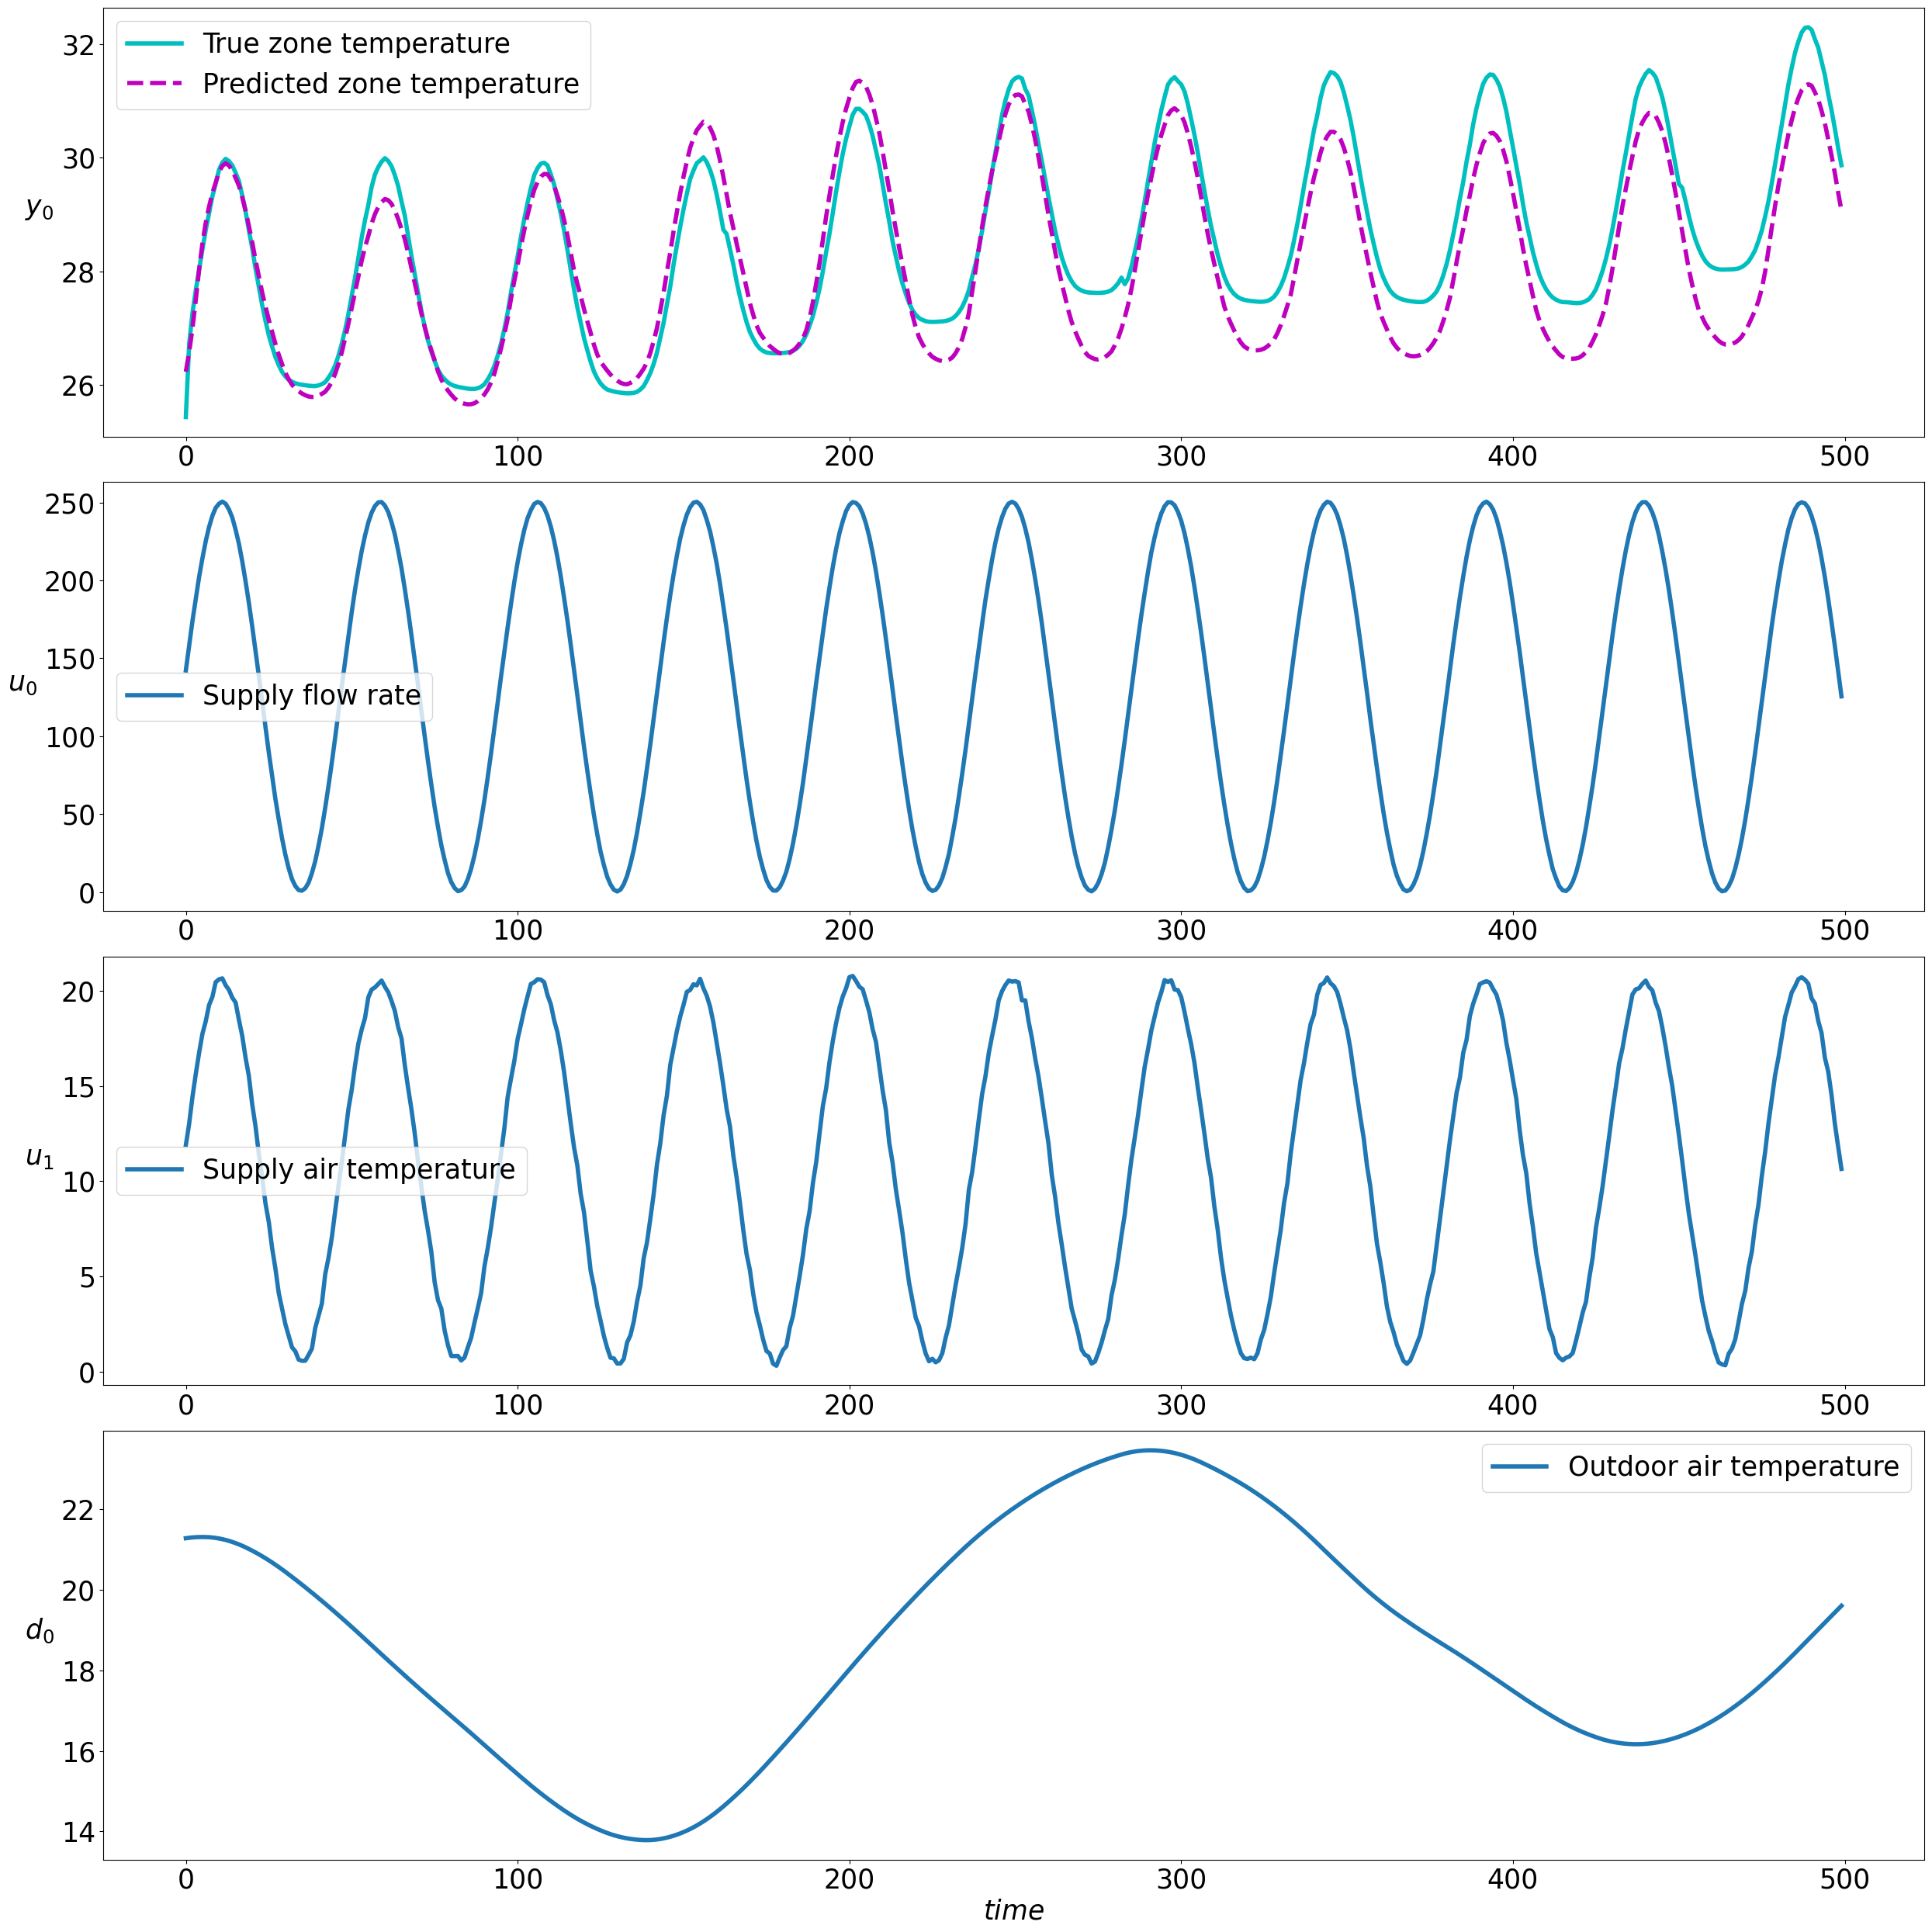

In [31]:
plt_nsteps = 500

# plot rollout
figsize = 25
fig, ax = plt.subplots(ny + nu + nd, figsize=(figsize, figsize))

x_labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, x_labels)):
    axe = ax[row]
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1[:plt_nsteps].numpy(), 'c', linewidth=4.0, label='True zone temperature')
    axe.plot(t2[:plt_nsteps], 'm--', linewidth=4.0, label='Predicted zone temperature')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)

u_labels = [f'$u_{k}$' for k in range(len(input_traj))]
u_description = ['Supply flow rate', 'Supply air temperature']
for row, (u, label, description) in enumerate(zip(input_traj, u_labels, u_description)):
    axe = ax[row+ny]
    axe.plot(u[:plt_nsteps], linewidth=4.0, label=description)
    axe.legend(fontsize=figsize)
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.tick_params(labelbottom=True, labelsize=figsize)

d_labels = [f'$d_{k}$' for k in range(len(dist_traj))]
for row, (d, label) in enumerate(zip(dist_traj, d_labels)):
    axe = ax[row+ny+nu]
    axe.plot(d[:plt_nsteps], linewidth=4.0, label='Outdoor air temperature')
    axe.legend(fontsize=figsize)
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.tick_params(labelbottom=True, labelsize=figsize)

ax[-1].set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()


